In [16]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
#from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [2]:
from google.colab import files, drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         #transforms.RandomRotation(degrees=15),
                                         #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         #transforms.RandomResizedCrop((224,224)),
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        #transforms.CenterCrop((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       #transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    if presplit:
        try:
            training_set = datasets.ImageFolder(root=images_path+'/train', transform=train_transform)
            validation_set = datasets.ImageFolder(root=images_path+'/val', transform=val_transform)
        except FileNotFoundError:
            raise Exception('Not presplit into Training and Validation sets')
        try:
            testing_set = datasets.ImageFolder(root=images_path+'/test', transform=test_transform)
        except:
            testing_set = validation_set
        dataset = training_set
    else:
        dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
        train_size = int(train_split * len(dataset))
        test_size = int(test_split * len(dataset))
        val_size = len(dataset) - train_size - test_size
        training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
    
    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

def load_network(net_model, net_name, dropout_ratio, class_names):
    for name, param in net_model.named_parameters():
        param.requires_grad = False

    if net_name.startswith('resnet'):
        num_ftrs = net_model.fc.in_features
        net_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Linear(256, len(class_names)))
        display(net_model)

    elif net_name.startswith('vgg'):
        num_ftrs = net_model.classifier[6].in_features
        net_model.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, 256),
                                                nn.ReLU(),
                                                nn.Dropout(p=dropout_ratio),
                                                nn.Linear(256, len(class_names)))
        display(net_model.classifier)
    
    total_params = sum(param.numel() for param in net_model.parameters())
    print(f'{total_params:,} total parameters')

    total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
    print(f'{total_trainable_params:,} training parameters')
    
    return net_model

In [4]:
def plot_images_per_class(images_path, mode, title):
    data_folder = images_path+'/'+mode+'/'
    item_dict = {root.split('/')[-1]: len(files) for root, _, files in os.walk(data_folder)}
   
    plt.figure(figsize=(20,8))
    plt.bar(list(item_dict.keys())[1:], list(item_dict.values())[1:], color='g')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

def plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=14):
    sampler = RandomSampler(training_set, num_samples=batch_size, replacement=True)
    train_loader = DataLoader(training_set, sampler=sampler, shuffle=False, batch_size=batch_size, num_workers=0)
    
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    plt.figure(figsize=(size,size))
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.title(class_names[labels.numpy()[i]])
        img = images[i].permute(1,2,0)
        img = torch.tensor(std)*img + torch.tensor(mean)
        plt.axis('off')
        plt.imshow(img, interpolation='none')
        plt.tight_layout()

In [5]:
def train_model(results_path, model_name, model, train_loader, val_loader, lr, epoch, momentum, weight_decay, patience, n_epochs_stop):
    """
    """
    if not os.path.exists(results_path+'/'+model_name):
        os.makedirs(results_path+'/'+model_name)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    #optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)
    
    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    y_testing = []
    preds = []
    
    min_val_loss = np.Inf
    epochs_no_improv = 0
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')
    
    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            if mode == 'val':
                model.eval()
            
            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, targets)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())
                
                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]
                
                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')
            
            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)
            
            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')
            
            if mode == 'val':
                scheduler.step(epoch_loss)
        
        if mode == 'val':
            if epoch_loss < min_val_loss:
                torch.save(model.state_dict(), str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'.pth')
                epochs_no_improv = 0
                min_val_loss = epoch_loss
            else:
                epochs_no_improv += 1
                print(f'Epochs with no improvement {epochs_no_improv}')
                if epochs_no_improv == n_epochs_stop:
                    print('Early stopping!')
                    return model, (losses, accuracies), y_testing, preds
                model.load_state_dict(torch.load(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'.pth'))
                    
    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

def test_model(model_name, model, test_loader):
    model.load_state_dict(torch.load(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    preds = []
    trues = []
    
    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()
            
        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [6]:
def display_confusion_matrix(results_path, model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):
    if not os.path.exists(results_path+'/'+model_name):
        os.makedirs(results_path+'/'+model_name)

    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)
    
    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)
    
    plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_conf_mat.png')
    
def plot_logs_classification(results_path, model_name, logs):
    """
    """
    if not os.path.exists(results_path+'/'+model_name):
        os.makedirs(results_path+'/'+model_name)
        
    training_losses, training_accuracies, test_losses, test_accuracies = \
        logs[0]['train'], logs[1]['train'], logs[0]['val'], logs[1]['val']
    
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    
    plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_graph.png')

In [7]:
project = 'dog_breeds/Images'
images_path = '/content/drive/My Drive/Colab Notebooks/Data/'+project
results_path = images_path+'_results'
presplit = False
train_split = 0.5
val_split = 0.25
test_split = 0.25
batch_size = 32
threads = 0
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

class_names = dataset.classes
class_names = [classes[10:] for classes in class_names]
print(class_names)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur

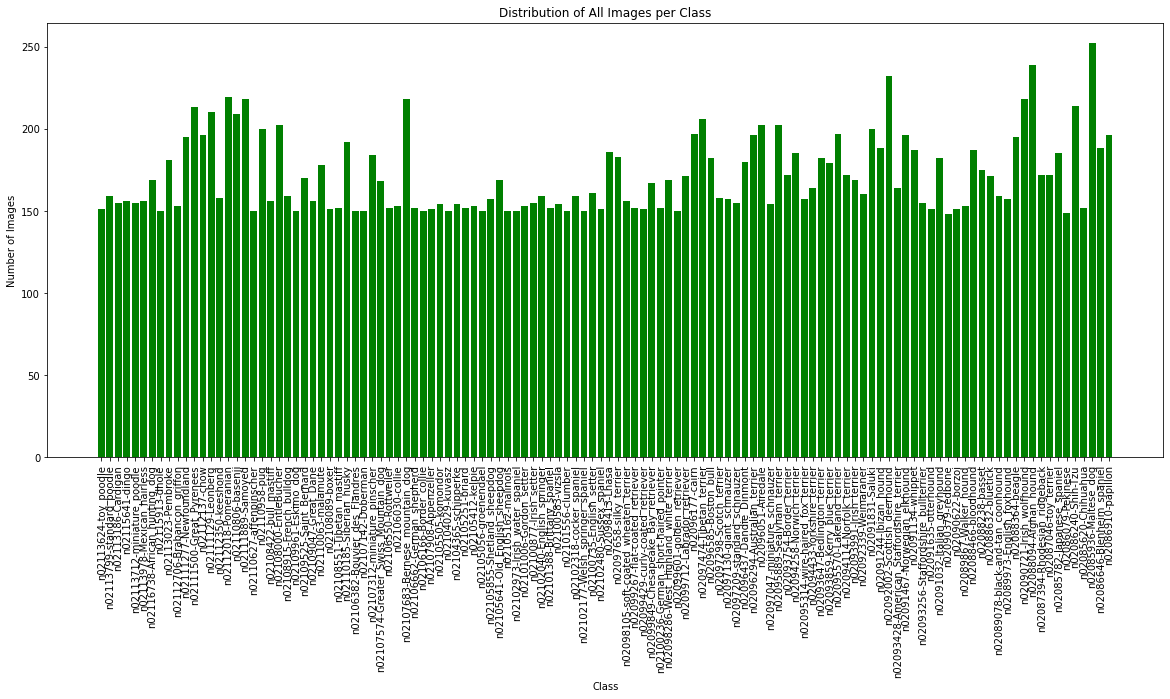

In [8]:
if presplit:
    plot_images_per_class(images_path, mode='train', title='Distribution of Training Data per Class')
    plot_images_per_class(images_path, mode='val', title='Distribution of Validation Data per Class')
    try:
        plot_images_per_class(images_path, mode='test', title='Distribution of Testing Data per Class')
    except:
        pass
else:
    plot_images_per_class(images_path, mode='', title='Distribution of All Images per Class')

In [9]:
net_model = resnet.resnet101(pretrained=True)
net_name = 'resnet101'

# net_model = models.vgg16()
# net_name = 'vgg16'

dropout_ratio = 0.25

net_model = load_network(net_model, net_name, dropout_ratio, class_names)

print(f'Images in training set {len(training_set)}, validation set {len(validation_set)}, testing set {len(testing_set)}')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

43,055,544 total parameters
555,384 training parameters
Images in training set 10290, validation set 5146, testing set 5145


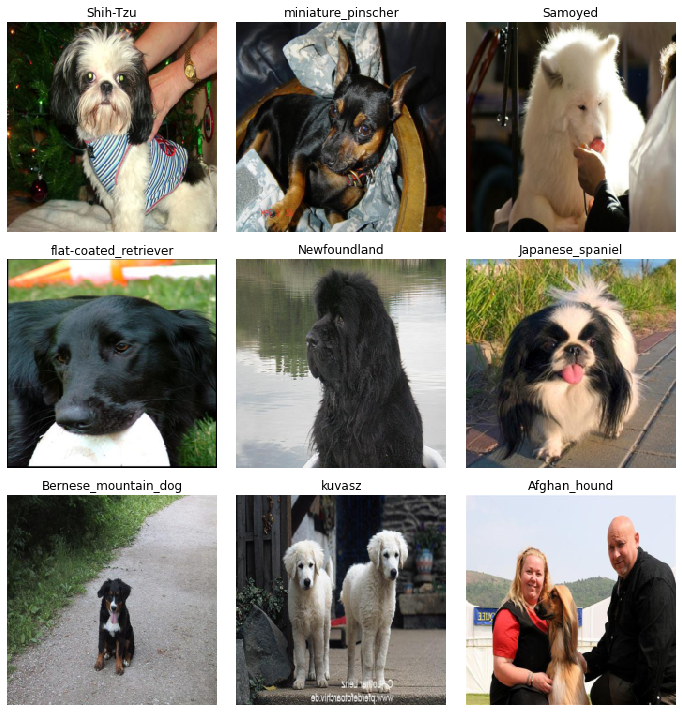

In [10]:
plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=10)

In [11]:
learning_rate = 0.001
epochs = 100
momentum = 0.9
weight_decay = 0
patience = 3
n_epochs_stop = 5

net_model, loss_acc, y_testing, preds = train_model(results_path, net_name, net_model, training_set_loader, validation_set_loader, 
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

Using 1 GPUs
[train] Epoch 1/100 Iteration 1/322 Loss: 4.83 Accuracy: 0.00
[train] Epoch 1/100 Iteration 65/322 Loss: 4.37 Accuracy: 0.10
[train] Epoch 1/100 Iteration 129/322 Loss: 3.68 Accuracy: 0.21
[train] Epoch 1/100 Iteration 193/322 Loss: 3.11 Accuracy: 0.30
[train] Epoch 1/100 Iteration 257/322 Loss: 2.71 Accuracy: 0.37
[train] Epoch 1/100 Iteration 321/322 Loss: 2.43 Accuracy: 0.42
[train] Epoch 1/100 Iteration 322/322 Loss: 2.43 Accuracy: 0.42
[val] Epoch 1/100 Iteration 1/161 Loss: 0.77 Accuracy: 0.75
[val] Epoch 1/100 Iteration 33/161 Loss: 0.87 Accuracy: 0.77
[val] Epoch 1/100 Iteration 65/161 Loss: 0.86 Accuracy: 0.77
[val] Epoch 1/100 Iteration 97/161 Loss: 0.86 Accuracy: 0.77
[val] Epoch 1/100 Iteration 129/161 Loss: 0.87 Accuracy: 0.76
[val] Epoch 1/100 Iteration 161/161 Loss: 0.88 Accuracy: 0.76
[val] Epoch 1/100 Iteration 161/161 Loss: 0.88 Accuracy: 0.76
[train] Epoch 2/100 Iteration 1/322 Loss: 1.35 Accuracy: 0.69
[train] Epoch 2/100 Iteration 65/322 Loss: 1.15 Acc

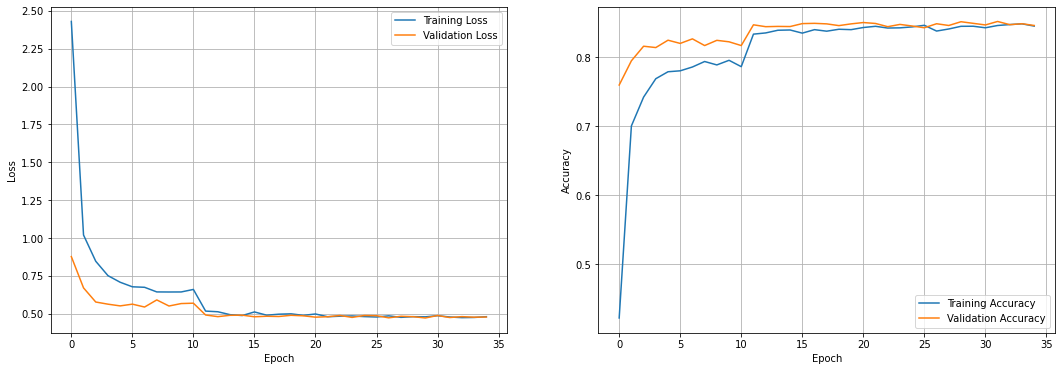

In [12]:
plot_logs_classification(results_path, net_name, loss_acc)

In [13]:
preds_test, y_true = test_model(net_name, net_model, testing_set_loader)

Iteration 1/161
Iteration 33/161
Iteration 65/161
Iteration 97/161
Iteration 129/161
Iteration 161/161


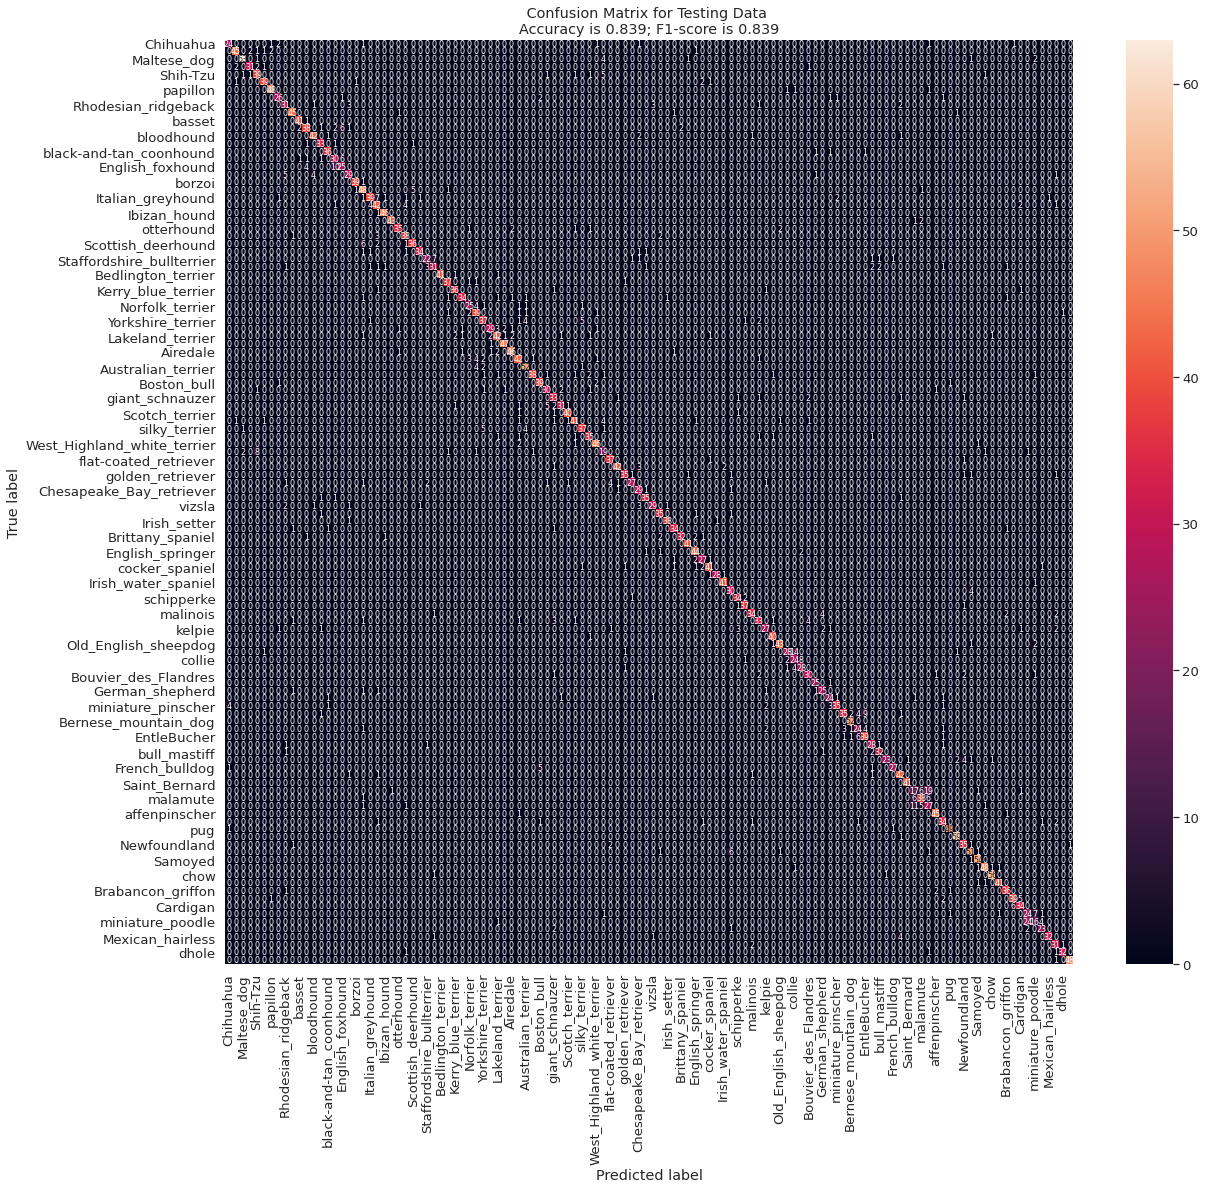

In [14]:
display_confusion_matrix(results_path, net_name, y_true, preds_test, class_names, annot=True, figsize=(19,17), fontsize=8)

In [15]:
print(classification_report(y_true, preds_test.argmax(1), target_names=class_names))

                                precision    recall  f1-score   support

                     Chihuahua       0.80      0.75      0.77        32
              Japanese_spaniel       0.92      0.87      0.89        52
                   Maltese_dog       0.94      0.88      0.91        72
                      Pekinese       0.91      0.84      0.87        37
                      Shih-Tzu       0.75      0.78      0.76        50
              Blenheim_spaniel       0.91      0.89      0.90        44
                      papillon       0.92      0.94      0.93        51
                   toy_terrier       0.84      0.81      0.83        32
           Rhodesian_ridgeback       0.72      0.76      0.74        41
                  Afghan_hound       0.90      0.94      0.92        48
                        basset       0.93      0.98      0.95        42
                        beagle       0.83      0.73      0.78        52
                    bloodhound       0.88      0.89      0.88  

In [ ]:
# class CustomTrainIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data["image"], batch_data["label"]
    
# custom_train_iter = CustomTrainIter(training_set_loader)

# criterion = nn.CrossEntropyLoss()
# # optimizer = Adam(net_model.parameters(), lr=1e-5, weight_decay=1e-2)
# optimizer = SGD(net_model.parameters(), lr=1e-5, momentum=momentum, weight_decay=weight_decay)

# # No lr_scheduler
# # Look for the lr where the curve has the greatest decline or steepest downward slope

# lr_finder = LRFinder(net_model, optimizer, criterion, device='cpu')
# lr_finder.reset()
# lr_finder.range_test(custom_train_iter, end_lr=100, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset()

In [ ]:
# class CustomValIter(ValDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data["image"], batch_data["label"]

# custom_val_iter = CustomValIter(validation_set_loader)
# lr_finder.reset()
# lr_finder.range_test(custom_train_iter, val_loader=custom_val_iter, end_lr=100, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset()